# Proyecto final de la Primera Evaluación
Este proyecto tiene como finalidad el entrenamiento y configuración de un modelo de Regresión Lineal simple y múltiple.

In [88]:
import pandas as pd
import numpy as np

from seaborn import pairplot, scatterplot, histplot, boxplot, heatmap, regplot
from matplotlib.pyplot import show

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from pickle import dump, load

In [4]:
path = '../data/datains_e.xlsx'
df = pd.read_excel(path)

## Estudio estructural de la base de datos 
Voy a utilizar un par de métodos de la librería `pandas` que me permitan observar la estructura de los datos dentro de la base de datos importada. 

*Inciso*:
Debemos eliminar la variable **index** del `DataFrame` ya que es una columna residual de los datos obetnidos para hacer el estudio .

In [5]:
df = df.drop(labels='index', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       196 non-null    float64
 1   sex       198 non-null    object 
 2   bmi       196 non-null    float64
 3   children  199 non-null    float64
 4   smoker    197 non-null    object 
 5   region    200 non-null    object 
 6   charges   200 non-null    float64
dtypes: float64(4), object(3)
memory usage: 11.1+ KB


### Análisis
Como se puede observar, contamos con **7 columnas** en una tabla con un total de **200 registros**.

**4** de las 7 columnas (`age`, `sex`, `bmi`, `children`, `smoker`) cuentan **valores nulos** que deberemos tratar más adelante.

Como indica `dtypes` en el informe, contamos con **4 variables númericas** y **3 variables categóricas** que tendremos que codificar posteriormente para estudiar su correlación con el **target**. 

En este caso, nuestra **variable objetivo o target** es el importe del seguro (`charge`) que depende del resto de variables; las **features o variables objetivo**.

Ahora, voy a obsevar también algunas **medidas estadísticas** que serán útiles a la hora de hacer el **escalado de valores**.

In [7]:
# Tabla con medidas estadísticas básicas para cada variable numérica
df.describe()

,age,bmi,children,charges
count,196.000000,196.000000,199.000000,200.000000
mean,39.948980,32.417857,1.075377,13790.512035
std,13.752294,22.629577,1.118868,12195.955051
min,18.000000,16.815000,0.000000,1121.873900
25%,27.750000,26.407500,0.000000,5451.159125
50%,40.000000,30.800000,1.000000,9526.937700
75%,51.000000,34.900000,2.000000,17610.229900
max,64.000000,334.700000,5.000000,52590.829390


## EDA (Análisis Exploratorio de Datos) 
Una vez estudiada la estrucutra básica de los datos, debemos realizar el EDA. Este proceso va a consistir en los siguientes pasos:
- Análisis descriptivo.
- Codificación de variables categóricas.
- Identificación y tratamiento de valores nulos -> **valores NaN**.
- Identificación y tratamiento de valores atípicos -> **outliers**.
- Escalado de los datos.
- Estudio de correlación entre las variables de la base de datos.

### Análisis descriptivo
En este proceso, voy a obsevar la **distribución de los datos** utilizando los **histogramas** y también su **concentración** a través de **diagramass de caja y bigote**. 
Para ello, voy a utilizar las funciones `histplot` y `boxplot` de la librería `seaborn`.

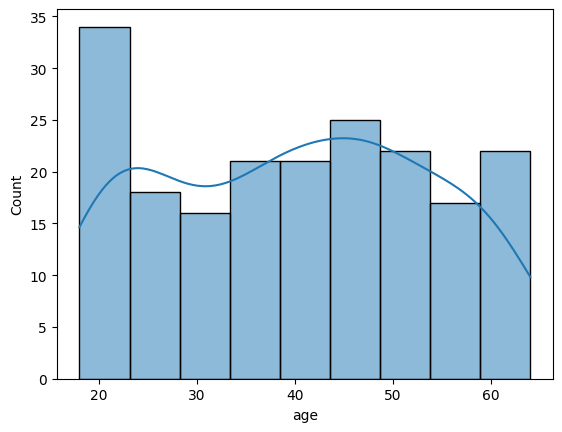

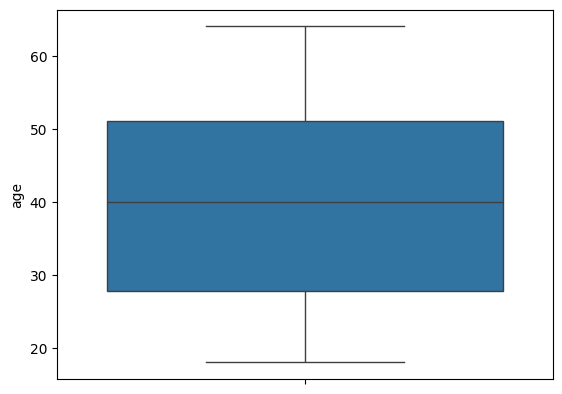

In [8]:
# Para la variable 'age'
col = 'age'
histplot(df[col], kde=True)
show()
boxplot(df[col])
show()

Para la variable **'age'**, los datos están basatante concetrados como muestran ambos gráficos. También se puede observar la ausencia de **outliers** y cierta asimetría en la distribución de los datos, pero sin presencia de un sesgo aparente.

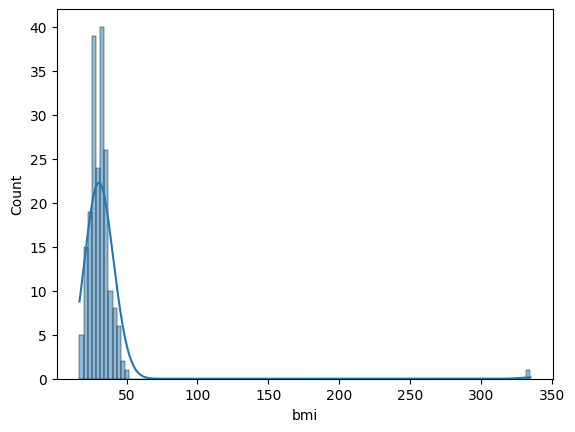

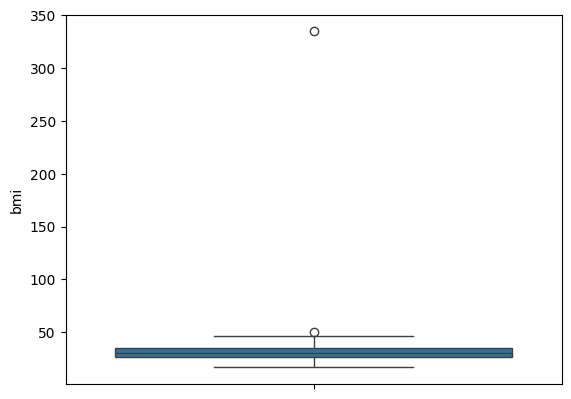

In [9]:
# Para la variable 'bmi'
col = 'bmi'
histplot(df[col], kde=True)
show()
boxplot(df[col])
show()

Para la variable **'bmi'**, la presencia de **outliers** es claramente notable. En la propia distribución de los datos se puede observar un valor que se encuentra completamente fuera del rango normal de los valores. Esto también se observa dentro del diagrama de caja y bigote que se encuentra debajo, donde encontramos al menos otro outlier más cercano al resto de valores. 

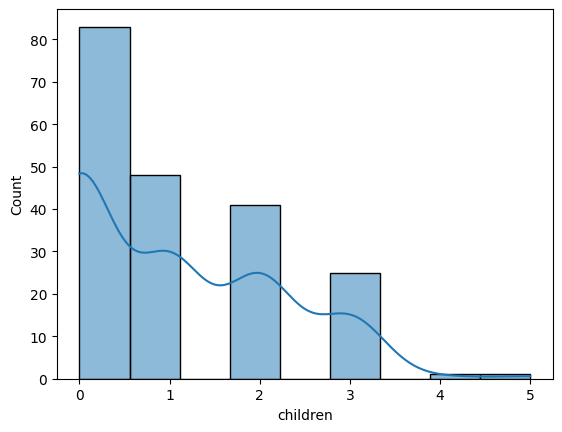

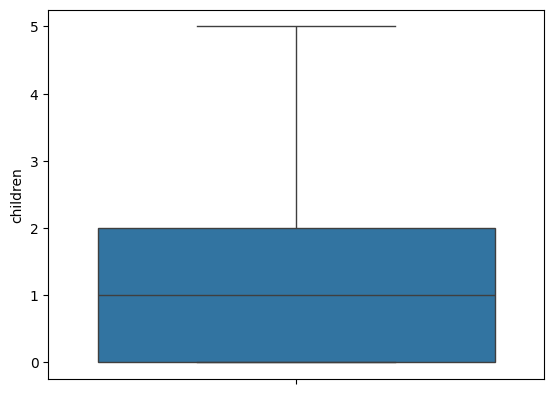

In [10]:
# Para la variable 'children'
col = 'children'
histplot(df[col], kde=True)
show()
boxplot(df[col])
show()

Para la variable **'children'**, encontramos una variable numérica discreta, ya que sólo toma valores dentro del rango [0, 5]. Podemos observar asimetría en la distribución de los datos, sesgada hacia la izquierda. Es notable también en los dos gráficos que la concentración de los datos la encontramos principalmente dentro del rango [0, 2], siendo 4 y 5 los valores más altos que puede tomar. En este caso no hay outliers al ser valores que se situán dentro de un rango razonable. 

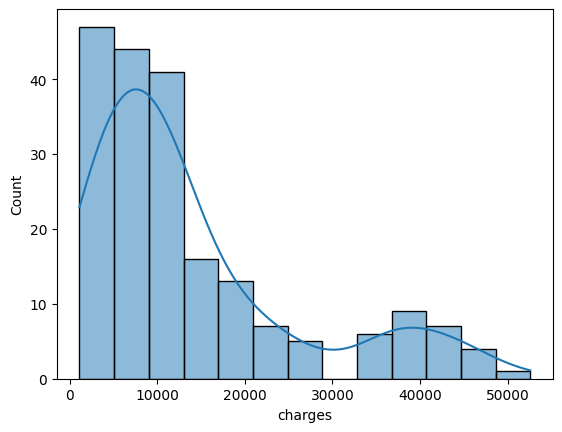

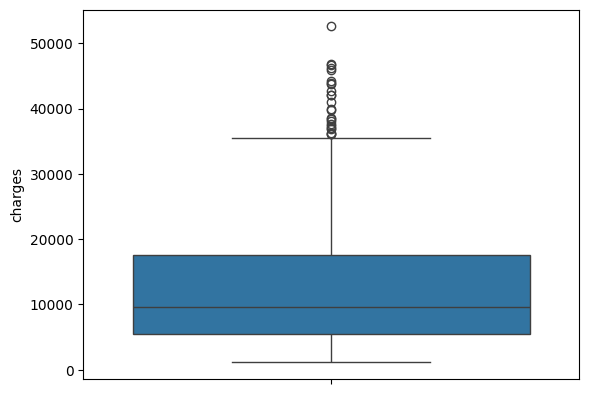

In [11]:
# Para la variable 'charges'
col = 'charges'
histplot(df[col], kde=True)
show()
boxplot(df[col])
show()

Para la variable **'charges'**, observamos una distribución similar a la anterior. Presenta asimetría positiva ya que está sesgada hacia la derecha. Se observa una gran concentración entre los valores **0 y 30000**. El resto de valores, como se representa en el diagrama de caja y bigote son outliers. En este caso, algunos de los valores atípicos podrían tratarse sólo de importes muy altos del seguro y teniendo en cuenta el bajo número de registros, no sería conveniente eliminar todos los outliers. 

De las variables categóricas podemos estudiar la medida estadística de la **moda**.

Puesto que ya contamos con la función `histplot` para representar diagramas de barras, podemos representar el recuento de valores que toma la variable categórica y de ahí sacar su moda.

<Axes: xlabel='region', ylabel='Count'>

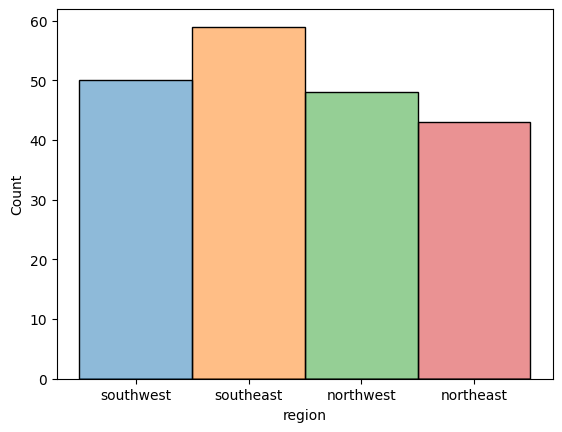

In [12]:
# Para la variable 'region'
col = df['region']
histplot(data=df, x=col, hue=col, legend=False)

Para la variable **'region'**, la tendencia a vivir es en el suroeste, ya que la moda para esta variable es **'southeast'**.

<Axes: xlabel='sex', ylabel='Count'>

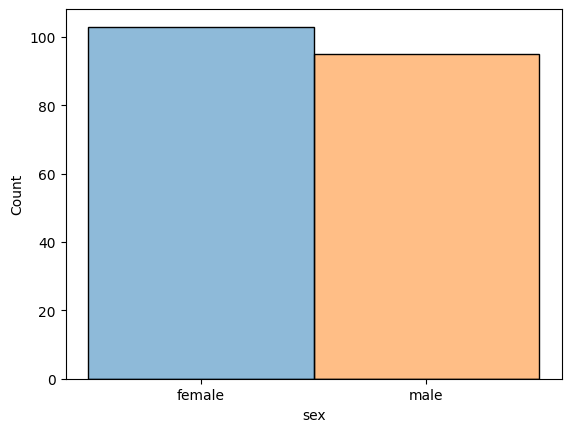

In [13]:
# Para la variable 'sex'
col = df['sex']
histplot(data=df, x=col, hue=col, legend=False)

Para la variable **'sex'**, se observa que la mayoría de contrataciones están realizadas por mujeres, puesto que la moda de esta variable es **'female'**.

<Axes: xlabel='smoker', ylabel='Count'>

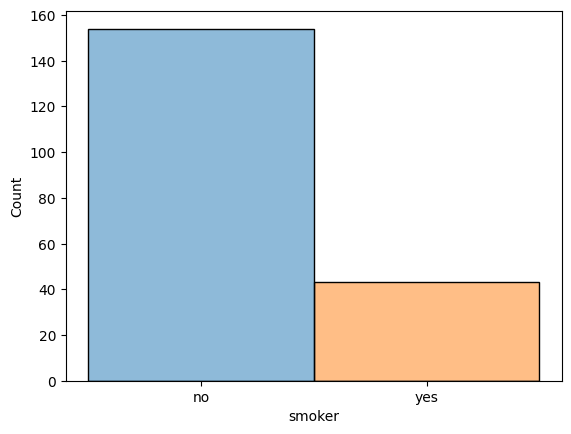

In [14]:
# Para la variable 'smoker'
col = df['smoker']
histplot(data=df, x=col, hue=col, legend=False)

Para la variable **'smoker'**, se observa una mayor tendencia a **no** ser fumador que a que sí, dado que la moda claramente para esta variable es **'no'**.

### Codificación de variables categóricas
Como había expuesto antes en la descripción estructural de los datos, contamos con **3 variables categóricas** a codificar dentro de nuestro DataFrame: `smoker`, `sex` y `region`.

Para las variables `sex` y `smoker` puesto que son de carácter binario, podemos emplear un simple mapeo de los valores categóricos a valores binarios utilizando la función `map` de `pandas`. 

Para la variable `region`, puesto que no presenta este carácter binario, podemos emplear el procedimiento de *dummieficación*. A través de este procedimiento, se genrarán **4 columnas** de carácter binario que indicarán el valor de `region` que toma un registro *x*. Una de las columnas podemos eliminarla debido a que se puede intuir su valor en función del valor de las restantes.

In [15]:
# Codificación de las variables 'sex' y 'smoker'
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

In [16]:
# Codificación de la variable 'region' por "dummieficación"
df = pd.get_dummies(data=df, columns=['region'], prefix='reg', drop_first=True, dtype='uint8')
df

,age,sex,bmi,children,smoker,charges,reg_northwest,reg_southeast,reg_southwest
0,23.0,0.0,33.400,0.0,0.0,10795.93733,0,0,1
1,18.0,1.0,23.210,0.0,0.0,1121.87390,0,1,0
2,49.0,0.0,29.925,0.0,0.0,8988.15875,1,0,0
3,57.0,1.0,NaN,0.0,0.0,11353.22760,1,0,0
4,64.0,1.0,34.500,0.0,0.0,13822.80300,0,0,1
...,...,...,...,...,...,...,...,...,...
195,55.0,0.0,25.365,3.0,0.0,13047.33235,0,0,0
196,30.0,1.0,24.400,3.0,1.0,18259.21600,0,0,1
197,47.0,1.0,28.215,3.0,1.0,24915.22085,1,0,0
198,34.0,1.0,30.800,0.0,1.0,35491.64000,0,0,1


Al habler implementado las versiones codificadas de `sex` y `smoker` dentro del `DataFrame`, podemos asignar directamente el `DataFrame` devuelto por la función `get_dummies()` al `DataFrame` original, puesto que ya contiene todas las variables codificadas correctamente.

### Tratamiento de valores nulos o NaN
Ahora que todas las variables están codificadas, voy a **imputar** aquellos valores **faltantes o nulos** presentes en el `DataFrame`.

Voy a realizar un recuento y visualización de los valores nulos a través de funciones de `pandas` y el mapa de calor de `seaborn`.

In [17]:
# Para ver un informe con el recuento de valores nulos presentes en el DataFrame 
df.isnull().sum()

age              4
sex              2
bmi              4
children         1
smoker           3
charges          0
reg_northwest    0
reg_southeast    0
reg_southwest    0
dtype: int64

<Axes: >

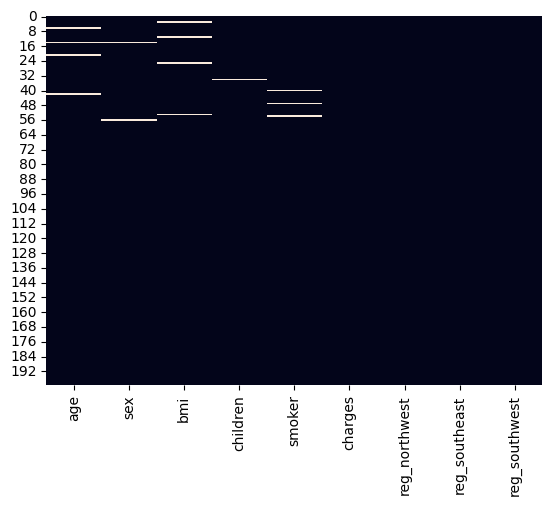

In [18]:
# Para observar los nulos en un mapa de calor utiliznado heatmap 
heatmap(data=df.isnull(), cbar=False)

En este caso contamos con una **baja cantidad** de valores nulos, por lo que el coste de computación a la hora de **imputarlos** será muy pequeño.

Mi plan de imputación es el siguiente:
- Para las variables numéricas discretas: `sex`, `smoker`, `children`; voy a imputar los valores nulos a la **moda** puseto que tomando un conjunto finito de valores y muy reducido es lo más coherente para completar el modelo.

- Para las variables numéricas continuas: `bmi`, `age`; voy a imputar los valores nulos a la **media**, puesto que utilizar la técnica de imputación por los *k-vecinos más cercanos* sería muy costoso e incoherente, ya que los registros cercanos no tienen relación directa con los registros nulos. 

In [19]:
# Imputación de las variables numéricas discretas 
df['sex'].fillna(value=df['sex'].mode()[0], inplace=True)
df['smoker'].fillna(value=df['smoker'].mode()[0], inplace=True)
df['children'].fillna(value=df['children'].mode()[0], inplace=True)

In [20]:
# Imputación de las variables numéricas continuas 
df['age'].fillna(value=df['age'].mean(), inplace=True)
df['bmi'].fillna(value=df['bmi'].mean(), inplace=True)

Ahora que los valores están imputados, podemos volver a comprobar que no haya restos de valores nulos trazando de nuevo el **mapa de calor anterior**. 

<Axes: >

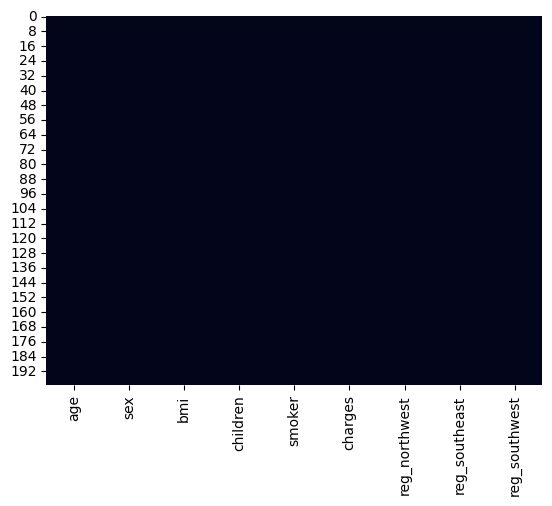

In [21]:
heatmap(df.isnull(), cbar=False)

Como se puede observar, los valores nulos ya han sido imputados correctamente.

### Tratamiento de outliers
Ya había detectado anteriormente los outliers en las variables `charges` y `bmi`. 
Voy a representar sus diagramas de caja y bigote de nuevo para analizar las posibilidades de tratamiento:

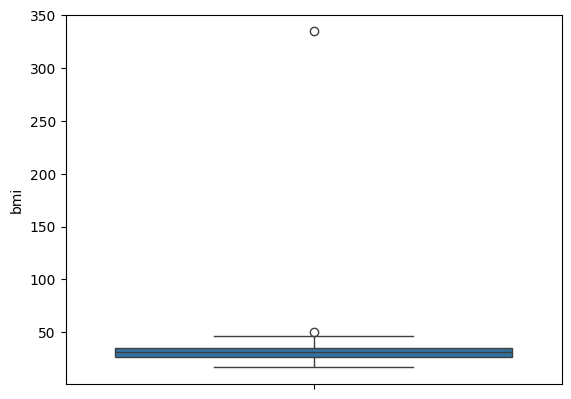

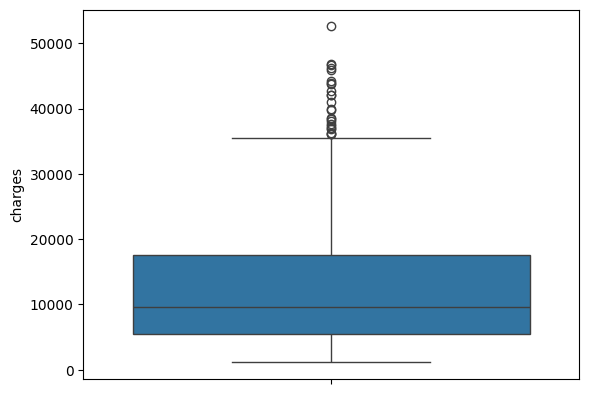

In [22]:
# Representación de los diagramas de caja y bigote
boxplot(df['bmi'])
show()
boxplot(df['charges'])
show()

Se puede observar claramente como uno de los valores del `DataFrame` está completamente alejado del resto para ambos casos. Outliers tan prominentes pueden afectar negativamente al rendimiento del modelo, por lo que es buena práctica **eliminarlos**. 

También se pueden observar otros outliers, esta vez más próximos al resto de valores. Teniendo en cuenta que el número de **registros** con el que contamos es bastante **bajo**, no sería muy conveniente deshacerse de ellos. Sin embargo, con el objetivo de buscar un modelo más preciso y eficiente, podemos observar qué pasa en cada uno de los casos. 

#### Eliminando los outliers más prominentes 
Para ello, como `pandas` no cuenta con una forma sencilla de eliminarlos, hay que emplear un método de filtrado para obtener el registro que contiene el **outlier** que deseamos eliminar. Como el valor atípico es tan desorbitado, convenientemente coincide con el valor **máximo** que toma la variable.

Para filtrar, voy a aprovechar la implementación nativa con la que cuentan los **arrays de numpy** de los operadores de comparación. En este caso, la intención es eliminar el registro que cuente con el valor máximo de la variable `bmi`.

In [23]:
# Dropeo de los registros con los outliers más prominentes en las columnas 'bmi' y 'charges'
bmi_out = np.where(df['bmi'] == df['bmi'].max())[0]
charges_out = np.where(df['charges'] == df['charges'].max())[0]

outlires_idx = np.append(bmi_out, charges_out)

df_out_partial = df.drop(outlires_idx)

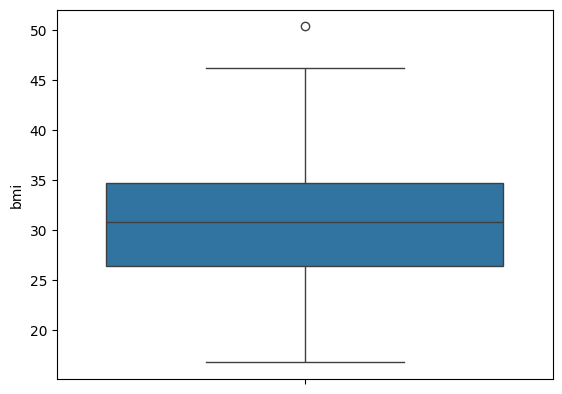

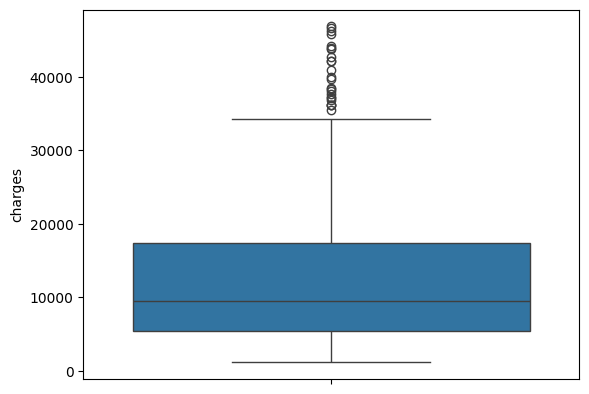

In [24]:
# Representación de los diagramas de caja y bigote
boxplot(df_out_partial['bmi'])
show()
boxplot(df_out_partial['charges'])
show()

En esta versión del `DataFrame` el rango de las variables `bmi` y `charges` es más reducido, y no cuenta con los outliers con los que contaba la versión original del `DataFrame` por lo que su rendimiento es mejor y el modelo no le otorga más peso a las variables que tenían mayor rango. 

#### Eliminando todos los outliers
Ahora voy a comprobar qué es lo que sucede cuando se eliminan todos los outliers (*o casi todos*) del `DataFrame`. Para detectarlos, la función `boxplot()` de seaborn utiliza un método que se conoce con el nombre de **Turkey** en el que se utiliza el **Índice Intercuartílico (IRQ)** para detecar los outliers.

Además de ese método, se puede emplear la detección de outliers por su **z-score** o **puntuación z**, que indica la desviación de los datos con respecto a la media en desviaciones estándar.

Para el caso del método **Turkey**, siendo x un valor cualquiera de una columna del `DataFrame`, es un outlier si se cumple:
$$
Q1-1.5\cdot IRQ > x < Q3+1.5\cdot IRQ\implies x\notin (Q1-1.5\cdot IRQ) \cup (Q3+1.5\cdot IRQ)
$$

Para el caso del **z-score**, de nuevo, siendo x un valor cualquiera de la columna del `DataFrame`, es un outlier si se cumple:
$$
2\sigma-\mu > x < 2\sigma+\mu\implies x\notin (2\sigma-\mu) \cup (2\sigma+\mu)
$$

En ambos casos, **1.5** y **2** son valores arbitrarios que se pueden **ajustar** para hacer un tratamiento de los outliers más efectivo.

In [25]:
std = df['charges'].std()
mean = df['charges'].mean()

charges_z_score = (df['charges'] - mean) / std
charges_outliers = np.where(charges_z_score > 0.88)[0]

*En este caso he tenido que ajustar el valor de **2** a **0.88** para terminar de eliminar todos los outliers*

In [26]:
q1 = df['bmi'].quantile(q=0.25)
q3 = df['bmi'].quantile(q=0.75)
irq = q3 - q1

bmi_outliers = np.where(df['bmi'] > q3 + 1.25*irq)

En este caso he tenido que modificar también el valor de **1.5** a **1.25** para eliminar todos los outliers.

In [27]:
df_out_full = df.drop(np.append(bmi_outliers, charges_outliers))
df_out_full.shape

(163, 9)

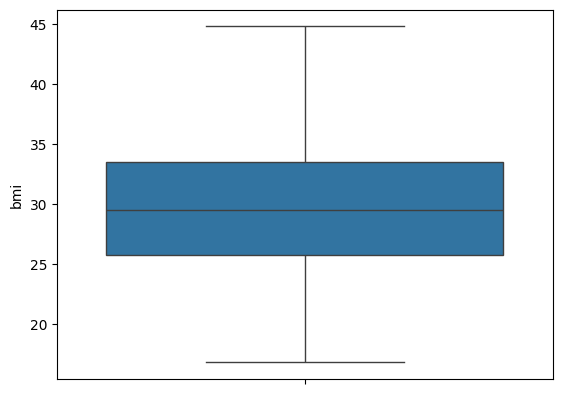

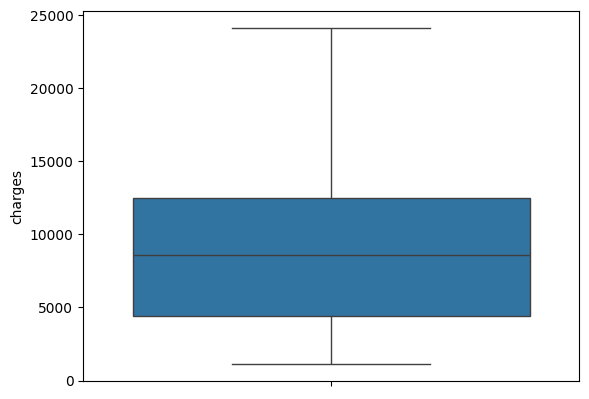

In [28]:
# Representación de los diagramas de caja y bigote
boxplot(df_out_full['bmi'])
show()
boxplot(df_out_full['charges'])
show()

En este caso ya no contamos con **outliers** en ninguna de las dos variables. Sin embargo, si miramos al número de registros resultante, el `DataFrame` se ve **mermado** casi en un **20%** de sus datos. Por lo que, lo que no se pierde de rendimiento por ausencia de valores atípicos se pierde por falta de registros. Aún así, la tendré en cuenta hasta poder analizar el **mapa de correlación**.

Por tanto, hasta la última fase del EDA, que es precisamente el estudio de la correlación entre los datos de la base de datos, estaré trabajando con **3 versiones** del `DataFrame` original:
- El `DataFrame` base
- El que he modificado para que no tuviese los **outliers** más prominentes.
- El que he modificado para que no tuviese **ningún outlier**.

### Escalado de variables
Para asegurar que todas las variables dentro del modelo reciben el mismo peso, voy a emplear el método de escalado **MinMax**; que consiste en *mappear* los valores de las variables del `DataFrame` al intervalo $[0, 1]$ para establecer el mismo **rango** entre todas.

Para escalar las variables del `DataFrame` voy a utilizar la clse `MinMaxScaler` de la librería `sklearn` que hará el prcoeso mucho más sencillo y eficiente.

In [29]:
# Referencia estática a las columnas del DataFrame original 
cols = df.columns

In [30]:
# Declaración de una instancia de MinMaxScaler para df
base_scaler = MinMaxScaler()
base_scaler.fit(df)

MinMaxScaler()

In [31]:
# Escalado de características para el DataFrame base
std_base_df = base_scaler.transform(df)
df = pd.DataFrame(std_base_df, columns=cols)
df

,age,sex,bmi,children,smoker,charges,reg_northwest,reg_southeast,reg_southwest
0,0.108696,0.0,0.052173,0.0,0.0,0.187959,0.0,0.0,1.0
1,0.000000,1.0,0.020117,0.0,0.0,0.000000,0.0,1.0,0.0
2,0.673913,0.0,0.041241,0.0,0.0,0.152836,1.0,0.0,0.0
3,0.847826,1.0,0.049083,0.0,0.0,0.198787,1.0,0.0,0.0
4,1.000000,1.0,0.055633,0.0,0.0,0.246769,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
195,0.804348,0.0,0.026897,0.6,0.0,0.231702,0.0,0.0,0.0
196,0.260870,1.0,0.023861,0.6,1.0,0.332965,0.0,0.0,1.0
197,0.630435,1.0,0.035862,0.6,1.0,0.462285,1.0,0.0,0.0
198,0.347826,1.0,0.043994,0.0,1.0,0.667777,0.0,0.0,1.0


*Anotción: estoy generando otro `DataFrame` puesto que la salida de la función `transform()` es un array de `numpy`, por lo que hay que tomar los datos de salida y convertirlos de nuevo a un `DataFrame` especificando además el nombre de las columnas, ya que evidentemente, no están incluidas en el array de `numpy`.*

In [32]:
# Declaración de una instancia de MinMaxScaler para df_out_partial
partial_scaler = MinMaxScaler()
partial_scaler.fit(df_out_partial)

MinMaxScaler()

In [33]:
# Escalado de características para el DataFrame sin outliers más prominentes 
std_partial_df = partial_scaler.fit_transform(df_out_partial)
df_out_partial = pd.DataFrame(std_partial_df, columns=cols)
df_out_partial

,age,sex,bmi,children,smoker,charges,reg_northwest,reg_southeast,reg_southwest
0,0.108696,0.0,0.494116,0.0,0.0,0.211375,0.0,0.0,1.0
1,0.000000,1.0,0.190526,0.0,0.0,0.000000,0.0,1.0,0.0
2,0.673913,0.0,0.390585,0.0,0.0,0.171875,1.0,0.0,0.0
3,0.847826,1.0,0.464855,0.0,0.0,0.223551,1.0,0.0,0.0
4,1.000000,1.0,0.526888,0.0,0.0,0.277510,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
193,0.804348,0.0,0.254730,0.6,0.0,0.260567,0.0,0.0,0.0
194,0.260870,1.0,0.225979,0.6,1.0,0.374444,0.0,0.0,1.0
195,0.630435,1.0,0.339640,0.6,1.0,0.519876,1.0,0.0,0.0
196,0.347826,1.0,0.416654,0.0,1.0,0.750966,0.0,0.0,1.0


In [34]:
# Declaración de una instancia de MinMaxScaler para df_out_full
full_scaler = MinMaxScaler()
full_scaler.fit(df_out_full)

MinMaxScaler()

In [35]:
# Escalado de características para el DataFrame sin outliers 
std_full_df = full_scaler.fit_transform(df_out_full)
df_out_full= pd.DataFrame(std_full_df, columns=cols)
df_out_full

,age,sex,bmi,children,smoker,charges,reg_northwest,reg_southeast,reg_southwest
0,0.108696,0.0,0.593275,0.0,0.0,0.420885,0.0,0.0,1.0
1,0.000000,1.0,0.228761,0.0,0.0,0.000000,0.0,1.0,0.0
2,0.673913,0.0,0.468968,0.0,0.0,0.342235,1.0,0.0,0.0
3,0.847826,1.0,0.558142,0.0,0.0,0.445131,1.0,0.0,0.0
4,1.000000,1.0,0.632624,0.0,0.0,0.552574,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
158,0.478261,1.0,0.618494,0.2,0.0,0.238343,0.0,0.0,0.0
159,0.565217,0.0,0.703452,0.0,0.0,0.507954,0.0,0.0,0.0
160,0.652174,0.0,0.551422,0.2,0.0,0.337144,0.0,1.0,0.0
161,0.804348,0.0,0.305849,0.6,0.0,0.518836,0.0,0.0,0.0


He creado una instancia del escalador por cada una de las versiones del `DataFrame` puesto que una vez que esté configurado el modelo y realice predicciones con él, será necesario revertir la estandarización de los valores para que las predicciones sean legibles.

Ahora que las **3 versiones** del `DataFrame` están escaladas, podemos finalizar el EDA con el estudio de la **correlación** entre las varaibles de la base de datos.

### Estudio de la correlación entre variables
Para comenzar a configurar los modelos de **regresión lineal**, tengo que decantarme por una de las 3 versiones que he generado del `DataFrame` original.
Para ello, voy a analizar la correlación entre las variables de las 3 versiones a través de un `heatmap` de `seaborn` para deliberar qué versión es más conveninente para hacer el modelo.

Partimos desde el conocimiento de que la **variable objetivo o target** en este caso es el importe de la póliza del seguro, que corresponde con la variable `charges`, por lo que tomaré eso como criterio a la hora de evaluar la conveniencia del `DataFrame`.

<Axes: >

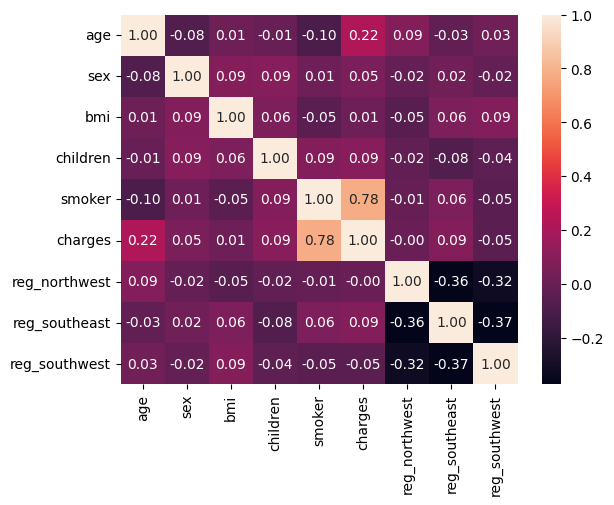

In [36]:
# Mapa de correlación para `df`
heatmap(df.corr(), annot=True, fmt='.2f')

En este caso, en el `DataFrame` base se puede observar claramente que la variable que más aportaría al modelo sería `smoker`, seguida de `age` con el segundo coeficiente de correlación más alto, con el que se podría realizar un modelo de regresión lineal múltiple. 

<Axes: >

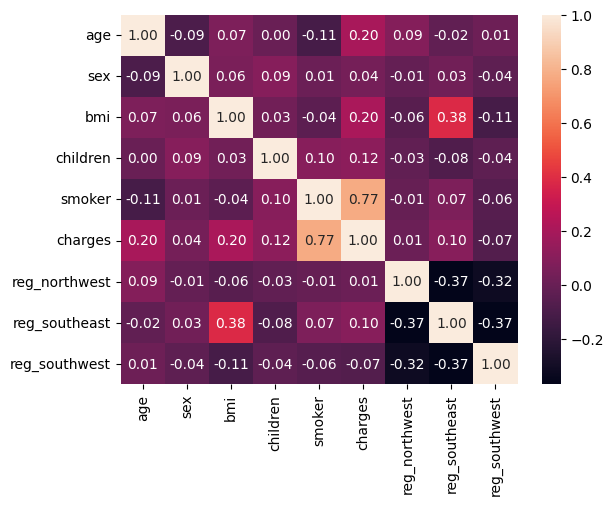

In [37]:
# Mapa de correlación para `df_out_partial`
heatmap(df_out_partial.corr(), annot=True, fmt='.2f')

En este caso, en el `DataFrame` al que le he eliminado los **outliers** más prominentes, se observa también que la variable que está más correlacionada con el **target** es `smoker`. Además, ahora `bmi` presenta un mayor coeficiente de correlación con respecto al **target**, por lo que sería viable para ser utilizada en el modelo.

También se observa cierta multicolinealidad entre `bmi` y `reg_southeast`, lo que resulta algo extraño pero no es relevante para el modelo, puesto que esas variables no van a ser utilizadas para el modelo final.

<Axes: >

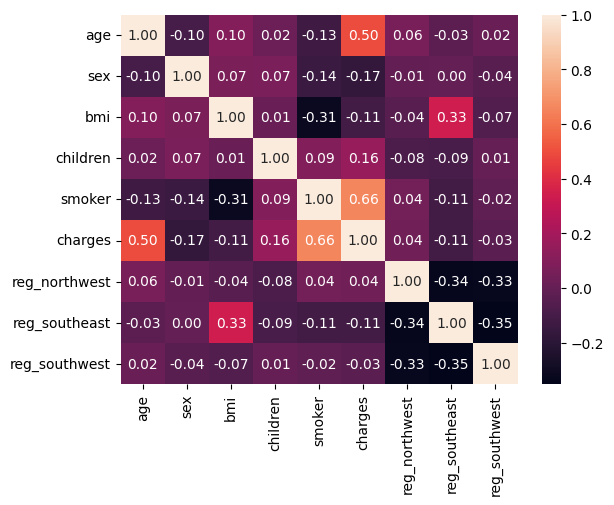

In [38]:
# Mapa de correlación para `df_out_full`
heatmap(df_out_full.corr(), annot=True, fmt='.2f')

Finalmente, en este último caso puede observarse como se acentúa la correlación de `age` con respecto a la variable `charge`. Un apunte que se puede realizar es que el fenómeno de multicolinealidad mencionado anteriormente parece haber disminuido un poco. 

Voy a decantarme por dos de las versiones para hacer los modelos correspondientes. 

Utilizaré el `DataFrame` original para el modelo de **regersión lineal simple** ya que tiene una característica bien marcada y correlacionada con la **variable objetivo**. 

Y utilizaré el `DataFrame` al que le he quitado el outlier más prominente, ya que mantiene más registros que el último (*por lo que puede ser más preciso*) y los coeficientes de correlación parecen estar en un mejor balance para el modelo.

Como nota, el fenómeno de multicolinealidad mencionado anteriormente no sería relevante dentro del modelo puesto que no afecta a la precisión de las predicciones y además la variable con la que sucede este fenómeno no va a ser empleada dentro del modelo.  

## División de los datos en *Train* y *Test*
Para iniciar con la selección y configuración del modelo, primero hay que dividir los datos de los `DataFrame` que se vayan a utilizar posteriormente en conjuntos de datos **train** y conjuntos de datos **test**. Puesto que el Machine Learning es un tipo de **aprendizaje supervisado** y por lo tanto los valores con los que se entrena el modelo tienen que ir etiquetados, es preciso probar el modelo con valores **no vistos** anteriormente. 

Como voy a realizar dos modelos de RL (*uno simple y uno múltiple*) con distintas versiones del `DataFrame`, asignaré a los conjuntos de datos del primer modelo el nombre de `X_base` e `y_base` para poder diferenciarlos del otro modelo, cuyos conjuntos recibirán el nombre de `X_mod` e `y_mod`.

Lo primero de todo, es guardar una referencia a la columna que representa la varaible **predictora**  y otra referencia a la variable **objetivo** del modelo.

#### Primer modelo (*RL simple*)

In [39]:
# Referencias para el primer modelo de regresión lineal 
X_base = df['smoker'] \
    .to_numpy() \
    .reshape(-1, 1)  # Transforma el array de numpy en un vector columna

y_base = df['charges'] \
    .to_numpy() \
    .reshape(-1, 1)

In [40]:
# División de los datos para el primer modelo 
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

#### Segundo modelo (*RL múlitple*)

In [41]:
# Referencias para el segundo modelo de regersión lineal
X_mod = df_out_partial.drop('charges', axis=1) \
    .to_numpy()

y_mod = df_out_partial['charges'] \
    .to_numpy() \
    .reshape(-1, 1)

In [42]:
# División de los datos para el segundo modelo
X_mod_train, X_mod_test, y_mod_train, y_mod_test = train_test_split(X_mod, y_mod, test_size=0.2, random_state=42)

## Selección y configuración del modelo de ML
Ahora que los datos han sido tratados y divididos en los conjuntos correspondientes para realizar los modelos queda el último paso, la configuración del propio modelo de Regresión Lineal. 
- Selección del modelo de **Machine Learning** -> **Regresión lineal**.
- Entrenamiento del modelo.
- Evaluación del modelo.

Para poder realizar una mejor evaluación del modelo de **Regresión Lineal Múltiple** voy a utiliar **3 tipos** de modelos de RL: 
- **LinearRegression**.
- **Lasso**.
- **Ridge**.

### Modelo de Regresión Lineal Simple
Para este caso, puesto que sólo hay **1 variable predictora o *feature***, voy a utilizar el modelo de Regresión Lineal estándar que viene con la librería `sklearn`.

#### Configuración y entrenamiento del modelo

In [43]:
# Delcaración del modelo
lr_base = LinearRegression()

In [44]:
# Entrenamiento del modelo
lr_base.fit(X_base_train, y_base_train)

LinearRegression()

In [45]:
# Realización de las predicciones con el modelo 
pred = lr_base.predict(X_base_test)
pred

array([[0.58933554],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.58933554],
       [0.58933554],
       [0.15481951],
       [0.15481951],
       [0.58933554],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.58933554],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.15481951],
       [0.58933554],
       [0.15481951],
       [0.58933554]])

Como se puede observar, sólo obtenemos dos tipos de predicciones: *0.58933554* y *0.15481951*. Es evidente la razón por la que esto sucede. Puesto que la variable elegida para ser la predictora dentro del modelo de regersión lineal es **discreta** y además **binaria**, sólo toma **2 valores** que al insertarlos dentro de la función que el modelo ha generado siempre devuelven el mismo valor.

Si aplicamos algunas métricas de evaluación sobre el modelo, se puede observar el **bajo rendimiento** del modelo:

#### Evaluación del modelo

In [46]:
# Métricas de evaluación sobre el modelo
r2_scr = r2_score(pred, y_base_test)
mse = mean_squared_error(pred, y_base_test)
mae = mean_absolute_error(pred, y_base_test)

print(f'El coeficiente R^2 del modelo es: {r2_scr:.2f}\nEl MSE del modelo es: {mse:.2f}\nEl MAE dl modelo es: {mae:.2f}')

El coeficiente R^2 del modelo es: 0.22
El MSE del modelo es: 0.02
El MAE dl modelo es: 0.12


Como se puede observar, sobre todo por el **coeficiente de determinación o coeficiente R^2** que proporciona información sobre el ajuste de las predicciones a los datos reales. Por lo general un coeficiente R^2 por debajo de **0.65** es un signo de mal modelo, y el caso de este modelo es de **0.22**, por lo que es **pésimo**.

Por ello, no lo tendré en cuenta a la hora de hacer el despliegue en la web, puesto que no tiene sentido incluirlo. 

### Modelo de Regresión Lineal Múltiple
Para este caso, voy a emplear el resto de variables como **features** para el modelo (`charges` se mantiene como **target**). Como esta vez se trata de un modelo de Regresión Lineal **multivariable o múltiple**, voy a configurar y comparar los **3 tipos** de modelo mencionados arriba. De ese modo (*teniendo en cuenta que el de RL simple no va a ser desplegado*), podré obtener un modelo con **mejor rendimiento**.

Como convención para nombrar los modelos utilizaré `lr` para el `LinearRegression`, `l1` para el `Lasso` y `l2` para el `Ridge`. Ambos, **Ridge y Lasso**, son variaciones del modelo estándar de RL que emplean un método de **regularización** para reducir coeficientes y evitar un posible caso de **overfitting** (*modelo incapaz de generalizar para valores no vistos*).

#### Entrenamiento de los modelos de RL múltiple

In [47]:
# Declaración de los modelos
lr = LinearRegression()
l1 = Lasso(alpha=0.5)  # alpha = 0.5 es el valor más utilizado para la penalización
l2 = Ridge(alpha=0.5)

In [48]:
# Entrenamiento de los modelos
lr.fit(X_mod_train, y_mod_train)
l1.fit(X_mod_train, y_mod_train)
l2.fit(X_mod_train, y_mod_train)

Ridge(alpha=0.5)

#### Análisis de *features* de los modelos 
Ahora que los modelos están entrenados, voy a analizar sus características básicas. Que son:
- `coef_` -> *coeficientes de la regresión*
- `intercept_` -> *ordenada en el origen*

In [49]:
# Características de lr
print(f'Los coeficientes de la regersión son: {lr.coef_}\nLa ordenada en el origen es: {lr.intercept_}')

Los coeficientes de la regersión son: [[ 0.25285832  0.01335135  0.34053216  0.03815752  0.52775818 -0.02644364
  -0.04003555 -0.02262532]]
La ordenada en el origen es: [-0.09358812]


En este caso, se puede observar que la ordenada en el origen es **negativa**. Esto tiene sentido, puesto que la mayoría de las variables tenían su valor mínimo por encima de 0, por lo que para cubrir los casos que van por debajo del mínimo, la ordenada en el origen debe estar más allá del mismo. 

In [50]:

# Características de l1
print(f'Los coeficientes de la regersión son: {l1.coef_}\nLa ordenada en el origen es: {l1.intercept_}')

Los coeficientes de la regersión son: [ 0.  0.  0.  0.  0.  0.  0. -0.]
La ordenada en el origen es: [0.27829972]


En este caso es interesante ver cómo el valor de penalización ha eliminado por completo todos los coeficientes de la regresión. 

Supongo que simplemente no podré utilizar este modelo para hacer predicciones 😆 

In [51]:
# Características de l2
print(f'Los coeficientes de la regersión son: {l2.coef_}\nLa ordenada en el origen es: {l2.intercept_}')

Los coeficientes de la regersión son: [[ 0.24336993  0.01387852  0.3049171   0.04122511  0.51606256 -0.02035205
  -0.03007483 -0.01819143]]
La ordenada en el origen es: [-0.0775351]


En el último caso, del modelo `Ridge`, se pueden observar unas carcterísticas muy similares a las del modelo de **Regresión Lineal estándar**, pero con los parámetros más reducidos. Este es precisamente el objetivo de este tipo de regularización, reducir los parámetros para **evitar el overfitting** y mejorar así el rendimiento de los modelos.

Por lo que las ecuaciones resultantes (*para los modelos que si sirven*) son:
- Para `lr`:
$$
y_{lr}=0.253\beta_1+0.013\beta_2+0.340\beta_3+0.038\beta_4+0.527\beta_5-0.026\beta_6-0.040\beta_7-0.022\beta_8
$$
- Para `l2`:
$$
y_{l2}=0.243\beta_1+0.014\beta_2+0.305\beta_3+0.041\beta_4+0.516\beta_5-0.020\beta_6-0.030\beta_7-0.018\beta_8
$$

Como se puede observar, las ecuaciones presentan unos coeficientes bajos precisamente por el escalado de variables realizado anteriormente con el MinMaxScaler y dichos coeficientes diferen muy poco, en el orden de centésimas o milésimas. 

#### Realización de predicciones
Ahora que los modelos están entrenados y analizados, voy a realizar predicciones sobre los modelos que han demostrado ser viables para la tarea.

In [52]:
# Realización de las predicciones para los modelos viables 
lr_pred = lr.predict(X_mod_test)
l2_pred = l2.predict(X_mod_test)

#### Evaluación de los modelos
Una vez analizados los modelos y hechas las predicciones, el siguiente paso es evaluar su rendimiento a través de algunas **métricas de evaluación**.

In [53]:
# Evaluación del primer modelo de RL -> `lr` 
lr_r2 = r2_score(y_mod_test, lr_pred)
lr_mse = mean_squared_error(y_mod_test, lr_pred)
lr_mae = mean_absolute_error(y_mod_test, lr_pred)

print(f'Evaluación del modelo \'lr\':\nCoeficiente R^2: {lr_r2:.4f}\nMSE: {lr_mse:.4f}\nMAE: {lr_mae:.4f}')

Evaluación del modelo 'lr':
Coeficiente R^2: 0.7478
MSE: 0.0133
MAE: 0.0822


In [54]:
# Evaluación del primer modelo de RL -> `l1` 
l2_r2 = r2_score(y_mod_test, l2_pred)
l2_mse = mean_squared_error(y_mod_test, l2_pred)
l2_mae = mean_absolute_error(y_mod_test, l2_pred)

print(f'Evaluación del modelo \'l2\':\nCoeficiente R^2: {l2_r2:.4f}\nMSE: {l2_mse:.4f}\nMAE: {l2_mae:.4f}')

Evaluación del modelo 'l2':
Coeficiente R^2: 0.7528
MSE: 0.0131
MAE: 0.0805


Ambos modelos rinden **bastante bien**. El **valor mínimo** establecido del **coeficiente de determinación o coeficiente R^2** es de $0.65$ y ambos modelos cuentan con un coeficiente R^2 de **~$0.75$**. Además, los errores medios cometidos son bastante bajos, están por debajo de $0.1$.

Aún así, es evidente que el modelo de **Regresión Lineal** con mejor rendimiento es el entrenado con la **Regularización L2**, que ha **minimizado** un poco los coeficientes para ajustarse mejor al modelo y **afinar las predicciones**.

## Ajuste de los modelos o *Tunning*
Antes de desplegar el modelo a la web, voy a emplear un método de ajuste para los modelos que he concluido como **viables** para ser utilizados en producción.

Este método recibe el nombre de ***cross-valiation*** o **validación cruzada** y consiste en evaluar el rendimiento del modelo cuando se entrena con **distintos conjuntos de entrenamiento**. Para probar distintas combinaciones de los posibles conjuntos de entrenamiento que se pueden generar, divide los datos en $n$ secciones (*especificadas por el operador*). Después, toma una de las secciones y la asigna como **conjunto de prueba**. Por lo que el resto de secciones se toma como **conjunto de entrenamiento**. Así, de forma reiterativa va probando cada una de las $n$ secciones hasta cubrir todos los casos.

Finalmente, resulta un **reporte de las métricas de evaluación especificadas** para cada uno de los casos.

Para ello, voy a emplear la función `cross_validate()` de `sklearn`.

In [73]:
# Tunning del modelo lr para n=3 secciones
lr_iter = cross_validate(lr, X_mod, y_mod, scoring='r2', cv=3, return_estimator=True, return_train_score=True)
print('Coeficiente R^2 de los modelos \'lr\' resutlantes:')

for score in lr_iter['train_score']:
    print(f'- {score:.4f}')

Coeficiente R^2 de los modelos 'lr' resutlantes:
- 0.7344
- 0.7813
- 0.7211


Como se puede observar, la **segunda** iteración del modelo ajustado presenta un coeficiente R^2 de ~$0.78$. Teniendo en cuenta que el modelo base, de **Regresión Lineal estándar**, tiene un coeficiente R^2 de ~$0.75$; ha habido una mejora de un ~$4$%, lo que está **muy bien** 👍.

In [80]:
# Tuning del modelo de l1 para n=3 secciones
l2_iter = cross_validate(l2, X_mod, y_mod, scoring='r2', cv=3, return_estimator=True, return_train_score=True) 
print('Coeficiente R^2 de los modelos \'l2\' resutlantes:')

for score in l2_iter['train_score']:
    print(f'- {score:.4f}')

Coeficiente R^2 de los modelos 'l2' resutlantes:
- 0.7332
- 0.7800
- 0.7199


En este caso, también encontramos mejora en la **segunda iteración**, incluso por debajo del modelo estándar (*aunque por muy poco*) cosa que pasaba a la inversa con los modelos bases que he entrenado anteriormente. De nuevo con un ~$4$% de mejora, también muy bien y dentro del rango de lo aceptable.

Ahora que sé qué modelos ajustados dan un mejor rendimiento que los base, puesto que he establecido en la función `cross_validate()` que me devolviese un array con los modelos ajustados (*en el parámetro `return_estimator`), puedo guardarlos como referncia en una variable para incluirlos dentro de los modelos posibles a utilizar en la página que voy a desplegar en los siguientes pasos. 

In [82]:
# Guardado de referencias de los modelos ajustados 
best_score_idx = 2
lr_tunned = lr_iter['estimator'][best_score_idx]
l2_tunned = l2_iter['estimator'][best_score_idx]

## Serializado del modelo
El último paso antes del **despliegue** del modelo en la web es la **serialización** de los modelos que queremos ofrecer para los usuarios que quieran probarlos. **Serializar** consiste en tomar un objeto de Python (*en este caso, instancia de las clases `LinearRegression()` y `Ridge()`) y codificar sus pesos y configuración en **archivos binarios** legibles por las plataformas en las que se va a desplegar el modelo. 

Para poder llevar a cabo la serialización, se requiere de una herramienta de **serializado** y **deserializado** de datos para poder utilizar el modelo. Para ello, Python cuenta con la librería `pickle` que es una herramienta perfecta para la serialización de modelos de **Machine Learning** sencillos como los de RL.
Otras librerías que pueden ser útiles para serializar modelos son: `joblib` o `tensorflow` (*para redes neuronales*).

Por lo que, puesto que quiero desplegar los cuatro modelos, voy a crear un **diccionario** con los nombres de cada modelo y su instancia correspondiente. De ese modo, el objeto que serializaré con la función `dump()` de pickle, será precisamente ese diccionario con todas las versoines del modelo.

In [83]:
# Declarando el diccionario con las versiones del modelo de Regresión Lineal
lr_ver_dict = {
    'LR Base': lr,
    'LR Ridge': l2,
    'LR Base Ajustada': lr_tunned,
    'LR Ridge Ajustada': l2_tunned
}

In [92]:
# Serialización y guardado de los modelos en el directorio '../models/'
path_to_models_dir = '../models'
filename = 'lr_models'
dump(lr_ver_dict, open(f'{path_to_models_dir}/{filename}.pkl', 'wb'))

Por fin, el último paso: **Despligue en la web**. Por lo que a este cuaderno respecta, ya he realizado todas los pasos que se podían realizar en un Cuaderno de Jupyter.
Para finalizar con el trabajo, voy a crear una **aplicación de Python** en el directorio `../apps/` que se encargará de incluir toda la parte del **Front-end** de la web, puseto que el **Back-end** ya ha sido programado, son los propio modelos.